In [ ]:
# !pip install --upgrade ipywidgets fastcore fastai diffusers datasets

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [2]:
# Specifying Dataset
dataset = 'mnist'

if dataset == 'mnist':
    mnist_dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, 
                                           transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,)) # << Normalized
                                            ]))
    train_dataloader = DataLoader(mnist_dataset, batch_size=128, shuffle=True)   

def display_image(im):
    if dataset == 'mnist':
        plt.imshow(im.detach(), cmap='Greys') # Let it handle scaling

tensor(0.0142) tensor(92.2913)


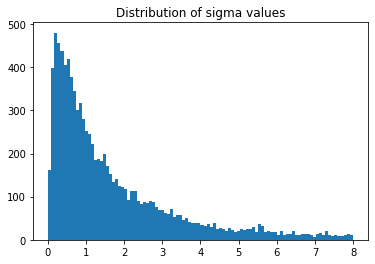

In [3]:
# Picking a noise distribution for training
sigma_mean, sigma_std = -1.2, 1.2
sigma_scale_factor = 4
distribution = torch.distributions.LogNormal(sigma_mean, sigma_std)
samples = distribution.sample([10000,]) * sigma_scale_factor
samples.min(), samples.max()
plt.hist([s for s in samples if s < 8], bins=100) # Clipping for visualization
plt.title('Distribution of sigma values')
print(samples.min(), samples.max())

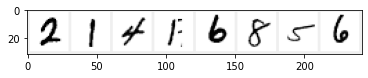

In [4]:
x, y = next(iter(train_dataloader))
display_image(torchvision.utils.make_grid(x[:8])[0])

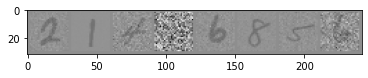

In [7]:
sigma = distribution.sample([x.shape[0],]) * sigma_scale_factor
noisy_x = x + torch.randn_like(x)*sigma.view(-1, 1, 1, 1)
display_image(torchvision.utils.make_grid(noisy_x[:8])[0])

Net has 1616449 parameters
Starting epoch 0
Average of the last 100 loss values: 0.06317429546266794
Starting epoch 1
Average of the last 100 loss values: 0.05488368410617113
Starting epoch 2
Average of the last 100 loss values: 0.05234638705849647
Starting epoch 3
Average of the last 100 loss values: 0.04945383284240961
Starting epoch 4
Average of the last 100 loss values: 0.049119308143854144
Starting epoch 5
Average of the last 100 loss values: 0.04716621726751327
Starting epoch 6
Average of the last 100 loss values: 0.046482900865375994
Starting epoch 7
Average of the last 100 loss values: 0.04677154466509819
Starting epoch 8
Average of the last 100 loss values: 0.047066312171518805
Starting epoch 9
Average of the last 100 loss values: 0.04624993871897459


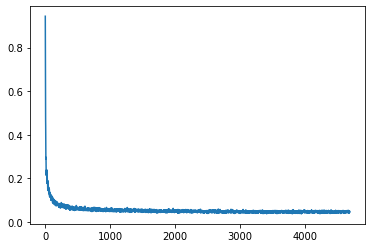

In [8]:
# How many runs through the data should we do?
n_epochs = 10

# Specify the net
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 64),  # <<< smaller than their eg
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
    ), 
    up_block_types=(
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
      ),
    attention_head_dim=4, # <<< Default is 8
)
net.to(device)
print(f'Net has {sum([p.numel() for p in net.parameters()])} parameters')

# Our loss finction
loss_fn = nn.MSELoss() # reduction='none' if want one per item for loss scaling

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-4) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
  print(f'Starting epoch {epoch}')
  for x, y in train_dataloader:

    # Get some data and prepare the corrupted version
    x = x.to(device) # Data on the GPU
    sigma = distribution.sample([x.shape[0]]).to(device) * sigma_scale_factor # Pick random noise amounts - here sigma_scale_factor x the base distribution!
    noise = torch.randn_like(x)
    noisy_x = x + noise*sigma.view(-1, 1, 1, 1) # Create our noisy x

    # Get the model prediction
    sigma_x = x.var().detach()**0.5 
    net_input = noisy_x/sigma_x.view(-1, 1, 1, 1) # Preondition input (papder does x * 1/(sigma**2 + sigma_data**2)**0.5)
    net_cond_input = (sigma_x*50).long() # COndition the net on std of x (not the true sigma value) <<< :)
    net_output = net(net_input, net_cond_input)
    pred_noise = net_output.sample # .sample since it returns a UNet2DOutput thingee

    # Calculate the loss as MSE between noise pred and actual noise
    loss = loss_fn(pred_noise, noise) #.mean(dim=(1, 2, 3), keepdim=False) 
    
    # Scale loss based on sigma edit don't since we're predicting non-scaled noise
    # loss = (loss / (1+sigma**2)).mean() # +1 for data var?

    # Backprop and update the params:
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Store the loss for later
    losses.append(loss.item())

  # Print our the average of the last 100 loss values to get an idea of progress:
  print('Average of the last 100 loss values:', sum(losses[-100:])/100)

  # Lower LR after 5 epochs
  if epoch == 5:
    for g in opt.param_groups:
      g['lr'] *= 0.2

# View the loss curve
plt.plot(losses)

Viewing the raw preds for some different inputs:

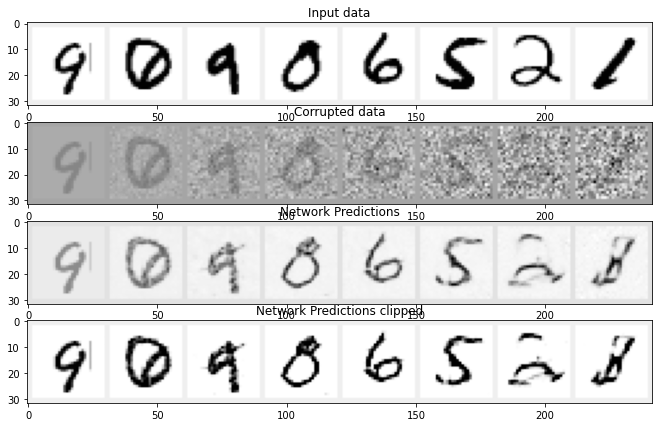

In [9]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
sigma = torch.linspace(0.002, 4, x.shape[0]) # Left to right -> more corruption
noise = torch.randn_like(x)
noised_x = x + noise*sigma.view(-1, 1, 1, 1)

# Get the model predictions
sigma_x = noised_x.var().detach() ** 0.5
with torch.no_grad():
    net_input = noised_x.to(device)/sigma_x.view(-1, 1, 1, 1).to(device) 
    net_cond_input = (sigma_x*50).long()
    net_output = net(net_input, net_cond_input)
    noise_pred = net_output.sample
preds = noised_x - noise_pred.cpu()*sigma.view(-1, 1, 1, 1)

# Plot
fig, axs = plt.subplots(4, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys') # .clip(x.min(), x.max())
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0], cmap='Greys')
axs[3].set_title('Network Predictions clipped')
axs[3].imshow(torchvision.utils.make_grid(preds.clip(x.min(), x.max()))[0], cmap='Greys')

Sampling as in the first notebook we made:

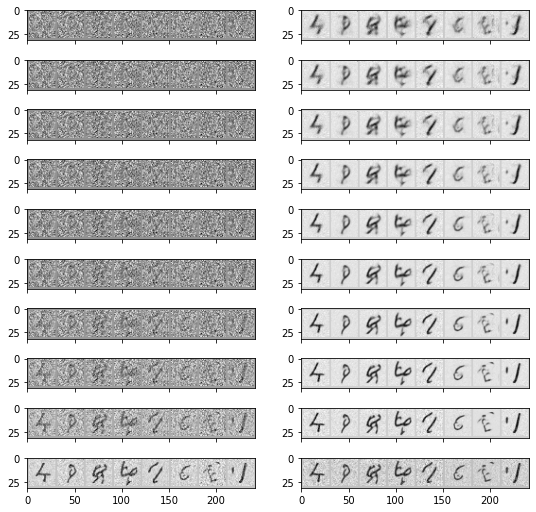

In [109]:
# Take one: just break the process into 10 steps and take 1/10'th of a step each time:
n_steps = 10

# Start from random (noised by sigma_start)
sigma_start = 14 # Explore changing this - it has quite an effect
x = torch.randn(8, 1, 28, 28)
noise = torch.randn_like(x)
x = x + noise*sigma_start


history = [x.detach().cpu()]
pred_history = []

for i in range(n_steps):
    # Estimate sigma and calc sigma_x
    sigma = max((x.var().detach()-1), torch.tensor(0.002).to(device))**0.5
    sigma_x = noised_x.var().detach() ** 0.5
    
    # Model outputs
    with torch.no_grad():
        net_input = x.to(device)/sigma_x.view(-1, 1, 1, 1).to(device) 
        net_cond_input = (sigma_x*50).long()
        net_output = net(net_input, net_cond_input)
        noise_pred = net_output.sample * sigma.view(-1, 1, 1, 1).to(device)
    
    # Predicted denoised image
    pred = x - noise_pred.cpu()
    pred_history.append(pred.cpu())
    
    # How much we move towards the prediction
    mix_factor = 1/(n_steps - i) 
    
    # Move part of the way there
    if i < n_steps - 1:
        x = x*(1-mix_factor) + pred*mix_factor 
        history.append(x.detach().cpu())
    else:
        x = pred
    
    

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 9), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(history[i])[0], cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_history[i])[0], cmap='Greys')

**NB: it seems here the first predicted output sets the shape pretty definitively. Unlike the previous demo where noise_amount went fm 0 to 1 and lerping between them made sense, here we probably want a better schedule. Or, a new way to sample :)**

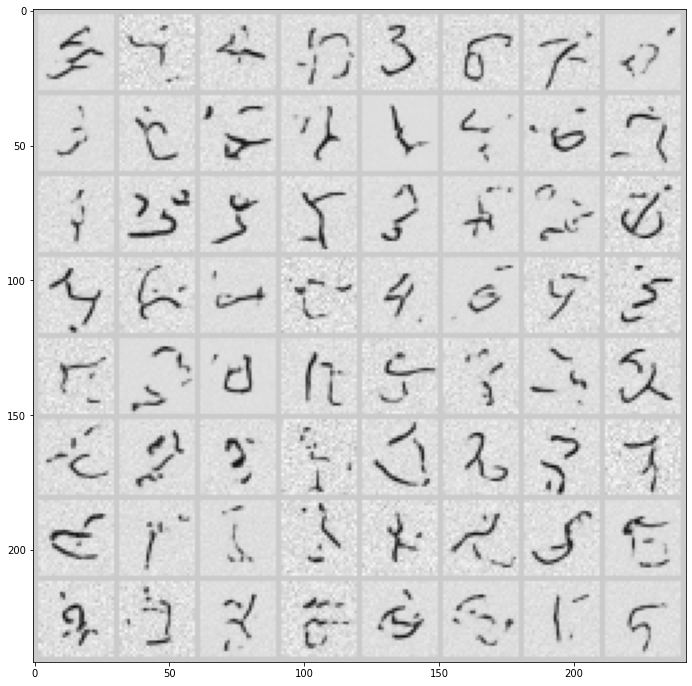

In [110]:
# A larger grid with more steps
n_steps = 5 # Explore
x = torch.randn(64, 1, 28, 28) * 7 # Explore start sigma here
history = [x.detach().cpu()]

for i in range(n_steps):
    # Estimate sigma and calc sigma_x
    sigma = max((x.var().detach()-1), torch.tensor(0.002).to(device))**0.5
    sigma_x = noised_x.var().detach() ** 0.5
    
    # Model outputs
    with torch.no_grad():
        net_input = x.to(device)/sigma_x.view(-1, 1, 1, 1).to(device) 
        net_cond_input = (sigma_x*50).long()
        net_output = net(net_input, net_cond_input)
        noise_pred = net_output.sample * sigma.view(-1, 1, 1, 1).to(device)
        
    pred = x - noise_pred.cpu()
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

Sampling with an optimiser instead:

0 0.04127277433872223 398.773681640625 N: 398.773681640625 20.02743911743164 2.6082656383514404
30 -0.006787281017750502 9.679652214050293 N: 9.679652214050293 3.14931058883667 2.6082656383514404
60 -0.013891845010221004 4.728640556335449 N: 4.728640556335449 2.250126838684082 2.6082656383514404
90 -0.026826534420251846 2.909149169921875 N: 2.909149169921875 2.2313363552093506 2.6082656383514404
120 -0.01638142392039299 0.45855456590652466 N: 0.45855456590652466 2.272484540939331 2.6082656383514404
Early stop at: 150


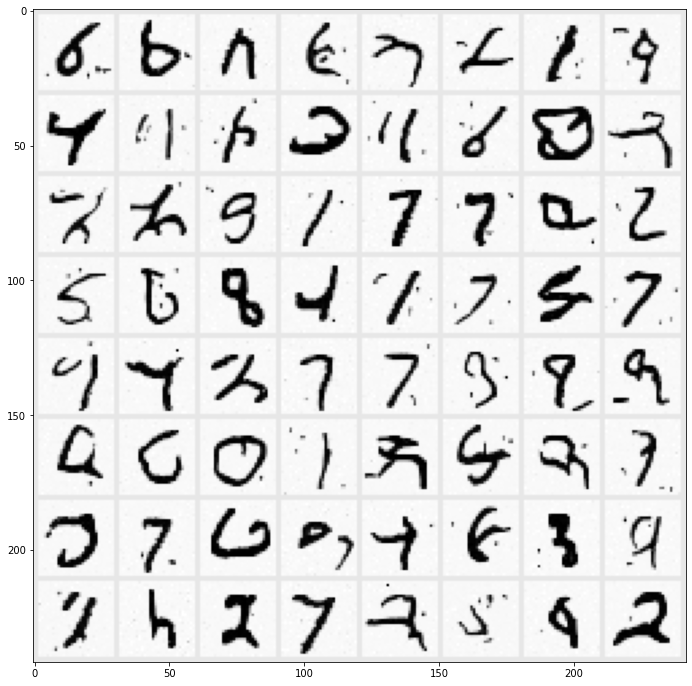

In [113]:
# Sample with Adam

n_steps = 250 # Can set high and use early stopping
x = torch.randn(64, 1, 28, 28).to(device)
start_sigma = 20 # Has a large effect
x = x + torch.randn_like(x) * start_sigma 

history = [x.detach().cpu()]

x.requires_grad = True

# Set up optimiser
base_lr= 0.05
optim = torch.optim.Adam([x], lr=2)

for i in range(n_steps):
    # Estimate sigma and calc sigma_x
    sigma = max((x.var().detach()-1), torch.tensor(0.002).to(device))**0.5
    sigma_x = noised_x.var().detach() ** 0.5
    
    # Model outputs
    with torch.no_grad():
        net_input = x.to(device)/sigma_x.view(-1, 1, 1, 1).to(device) 
        net_cond_input = (sigma_x*50).long()
        net_output = net(net_input, net_cond_input)
        noise_pred = net_output.sample * sigma.view(-1, 1, 1, 1).to(device)
        
    # Early stopping based on variance of noise pred
    if (noise_pred.float()).var() < 0.1:
        x = x - noise_pred # Predicted output
        print('Early stop at:', i)
        break
    
    # Predicted output on final step
    if i == n_steps - 1:
        x = x - noise_pred
        break
        
    # Adjust lr based on sigma - it helps to start at a high lr
    # but that can be an issue closer to the solution. A schedule
    # or momentum would fix this I think.
    if i > 50:
        for g in optim.param_groups:
            g['lr'] = base_lr * max(sigma, 0.5)

    # noise_pred is basically the grad, so GD on this should find a minimum!
    x.grad = noise_pred.float()
    if i%30==0:print(i, x.grad.mean().item(), 
                     x.grad.var().item(), 
                     'N:', noise_pred.float().var().item(), 
                     sigma.item(), sigma_x.item())
    optim.step()
    optim.zero_grad()

# Visualize
x = x.clamp(x.quantile(0.01), x.quantile(0.99))
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

In [114]:
# Sample with DDIM
from diffusers import LMSDiscreteScheduler

# This from https://github.com/crowsonkb/k-diffusion/blob/master/k_diffusion/sampling.py
def append_zero(x):
    return torch.cat([x, x.new_zeros([1])])

def get_sigmas_karras(n, sigma_min, sigma_max, rho=7., device='cpu'):
    """Constructs the noise schedule of Karras et al. (2022)."""
    ramp = torch.linspace(0, 1, n)
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
    return append_zero(sigmas).to(device)

In [ ]:
# Create new scheduler and set num inference steps
n_inference_steps = 60
scheduler = LMSDiscreteScheduler()
scheduler.set_timesteps(num_inference_steps=n_inference_steps)

# hack in new sigmas
sigma_min, sigma_max = 1e-2, 9 # sigma_max changes things a fair bit
sigmas = get_sigmas_karras(n_inference_steps, sigma_min, sigma_max, rho=4.)
scheduler.sigmas = sigmas

# And the fake timesteps we'd use for conditioning the model at these sigmas
# scheduler.timesteps = [(torch.log(s.to(device))*n_inference_steps).long() for s in scheduler.sigmas]

x = torch.rand(64, 1, 28, 28) 
x += torch.randn_like(x)*scheduler.sigmas[0] # Noisy starting point

for i, t in enumerate(scheduler.timesteps[:-1]):    
    # Estimate sigma and calc sigma_x
    sigma_scheduler = scheduler.sigmas[i]
    sigma_est = max((x.var().detach()-1), torch.tensor(0.002).to(device))**0.5
    sigma_x = noised_x.var().detach() ** 0.5
    
    # Model outputs
    with torch.no_grad():
        net_input = x.to(device)/sigma_x.view(-1, 1, 1, 1).to(device) 
        net_cond_input = (sigma_x*50).long()
        net_output = net(net_input, net_cond_input)
        noise_pred = net_output.sample * sigma_scheduler.view(-1, 1, 1, 1).to(device)
    
    if i%20==0:print(i, sigma_scheduler, sigma_est, x.var().item(), noise_pred.var().item())

    # compute the previous noisy sample x_t -> x_t-1
    x = scheduler.step(noise_pred.cpu(), i, x, order=4)["prev_sample"]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

0 tensor(9.0000) tensor(8.9296) 80.73719787597656 79.24813842773438
20 tensor(2.4579) tensor(2.1682) 5.701184272766113 5.912394046783447
40 tensor(0.3555) tensor(1.3655) 2.8647196292877197 0.1159992665052414


### At sigma_max = 4, output is heiroglyphs. 8-10 suddenly starts getting very sensible. 20 it's less variety?

### Can play with rho - 7 is default, 3 seemed to give more variety